In [73]:
import json

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import community as community_louvain

source_df = pd.read_csv('data/global_arms_transfer_2000_2023.csv')
source_df.sample(10)

,id,trade_id,target,source,order_date,orderYrEst,quantity,delivery_date,designation,description,category,source_lat,source_lng,target_lat,target_lng
7253,253133,60870,South Korea,Germany,2013-01-01 00:00:00+00:00,True,4.0,2016-01-01 00:00:00+00:00,ship engine 8001-11000,ship engine,Engines,51.247366,10.298068,36.447642,127.822588
3836,263286,52177,Romania,United States,2010-01-01 00:00:00+00:00,False,60.0,2010-01-01 00:00:00+00:00,MaxxPro,APC,Armoured vehicles,38.893651,-77.170630,45.891928,24.937764
8006,248186,62422,South Korea,United States,2017-01-01 00:00:00+00:00,False,290.0,2018-01-01 00:00:00+00:00,JDAM,guided bomb,Missiles,38.893651,-77.170630,36.447642,127.822588
5923,237758,58065,Japan,Australia,2014-01-01 00:00:00+00:00,False,4.0,2014-01-01 00:00:00+00:00,Bushmaster -,APC,Armoured vehicles,-26.234939,134.617710,37.968876,138.248252
1462,302492,34998,Indonesia,Poland,2005-01-01 00:00:00+00:00,False,1.0,2007-01-01 00:00:00+00:00,KOBRA,AA gun/SAM system,Air defence systems,52.211251,19.294992,-2.234137,117.431827
870,300995,32710,Taiwan,United States,2003-01-01 00:00:00+00:00,True,148.0,2006-01-01 00:00:00+00:00,SM-2MR,SAM,Missiles,38.893651,-77.170630,23.748102,120.976108
9702,317335,65980,UAE,South Korea,2020-01-01 00:00:00+00:00,True,NaN,NaN,LOGIR,anti-ship missile/ASM,Missiles,36.447642,127.822588,23.875788,54.210894
1824,308441,36049,Mali,Czechia,2005-01-01 00:00:00+00:00,False,3.0,2005-01-01 00:00:00+00:00,MiG-21MF,fighter aircraft,Aircraft,49.785077,15.330424,17.368265,-3.517670
7135,252012,60600,Iraq,Spain,2014-01-01 00:00:00+00:00,False,231.0,2016-01-01 00:00:00+00:00,VAMTAC,APV,Armoured vehicles,40.434162,-3.614563,33.108923,43.742038
5682,231364,57321,Malawi,South Africa,2013-01-01 00:00:00+00:00,False,13.0,2015-01-01 00:00:00+00:00,Marauder -,APC,Armoured vehicles,-29.071408,24.993023,-13.194468,34.197227


In [74]:
len(source_df)

10520

In [75]:
edge_df = source_df.copy(deep=True)
edge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10520 entries, 0 to 10519
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10520 non-null  int64  
 1   trade_id       10520 non-null  int64  
 2   target         10520 non-null  object 
 3   source         10520 non-null  object 
 4   order_date     10520 non-null  object 
 5   orderYrEst     10516 non-null  object 
 6   quantity       10292 non-null  float64
 7   delivery_date  8841 non-null   object 
 8   designation    10520 non-null  object 
 9   description    10520 non-null  object 
 10  category       10520 non-null  object 
 11  source_lat     10360 non-null  float64
 12  source_lng     10360 non-null  float64
 13  target_lat     10138 non-null  float64
 14  target_lng     10138 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 1.2+ MB


In [76]:
edge_df.dropna(inplace=True)
edge_df = edge_df[edge_df['category'] == 'Missiles']
edge_df = edge_df[edge_df['order_date'] >= '2014-01-01']

In [77]:
edge_df = edge_df.groupby(['source', 'target'])["quantity"].sum().reset_index(name='weight')

In [78]:
# Create a MultiDiGraph
network = nx.DiGraph()
for _, row in edge_df.iterrows():
    network.add_edge(row['source'], row['target'], **row.to_dict())
print(network)

DiGraph with 100 nodes and 235 edges


In [79]:
def compute_louvain_communities(
    input_graph: nx.MultiDiGraph
) -> nx.Graph:
        community_graph = input_graph.copy(as_view=False)
        community_graph = community_graph.to_undirected()
        partition_dict = community_louvain.best_partition(
            community_graph, weight="weight", resolution=0.9, random_state=1
        )

        return partition_dict

partition_dict = compute_louvain_communities(network)
# print number of unique values
len(set(partition_dict.values()))

5

In [80]:
def compute_node_attributes(input_graph: nx.Graph, partition_dict) -> nx.Graph:
    new_graph = input_graph.copy(as_view=False)
    # Degrees
    in_degree = dict(new_graph.in_degree())
    out_degree = dict(new_graph.out_degree())
    nx.set_node_attributes(new_graph, in_degree, 'in_degree')
    nx.set_node_attributes(new_graph, out_degree, 'out_degree')
    #Clustering coefficient
    clustering_coeffs = nx.clustering(new_graph)
    nx.set_node_attributes(new_graph, clustering_coeffs, name="clustering_coefficient")
    # Betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(new_graph)
    nx.set_node_attributes(new_graph, betweenness_centrality, name="betweenness_centrality")
    # Closest centrality
    closeness_centrality = nx.closeness_centrality(new_graph)
    nx.set_node_attributes(new_graph, closeness_centrality, name="closeness_centrality")
    # Eigenvector centrality
    # eigenvector_centrality = nx.eigenvector_centrality(new_graph)
    # nx.set_node_attributes(new_graph, eigenvector_centrality, name="eigenvector_centrality")
    # Strength centrality
    strengths = {node: sum(data["weight"] for neighbor, data in new_graph[node].items()) for node in new_graph.nodes()}
    nx.set_node_attributes(new_graph, strengths, name="strength")
    
    nx.set_node_attributes(new_graph, partition_dict, "louvain_community")
    return new_graph

network = compute_node_attributes(input_graph=network, partition_dict=partition_dict)

In [81]:
def convert_networkx_to_echarts(graph: nx.DiGraph) -> None:
    """This method exports Network data for echarts Chord visualization"""
    echarts_graph = {
        'nodes': [],
        'edges': [],
        'categories': []
    }

    # Adding nodes with categories if necessary
    for node, data in graph.nodes(data=True):
        node_entry = {
            'name': str(node),
            'category': data.get('category', 'default')
        }
        node_entry.update(data)
        echarts_graph['nodes'].append(node_entry)
    
    # Adding edges with all attributes
    for source, target, attributes in graph.edges(data=True):
        edge_entry = {
            'source': str(source),
            'target': str(target)
        }
        # Include all edge attributes in the edge entry
        edge_entry.update(attributes)
        echarts_graph['edges'].append(edge_entry)
    
    unique_communities = list(
        set(nx.get_node_attributes(graph, "louvain_community").values())
    )
    echarts_graph["categories"] = [{"name": str(i)} for i in unique_communities]
    
    with open('output/html_charts/chord_diagram.json', 'w') as f:
        json.dump(echarts_graph, f)

convert_networkx_to_echarts(network)

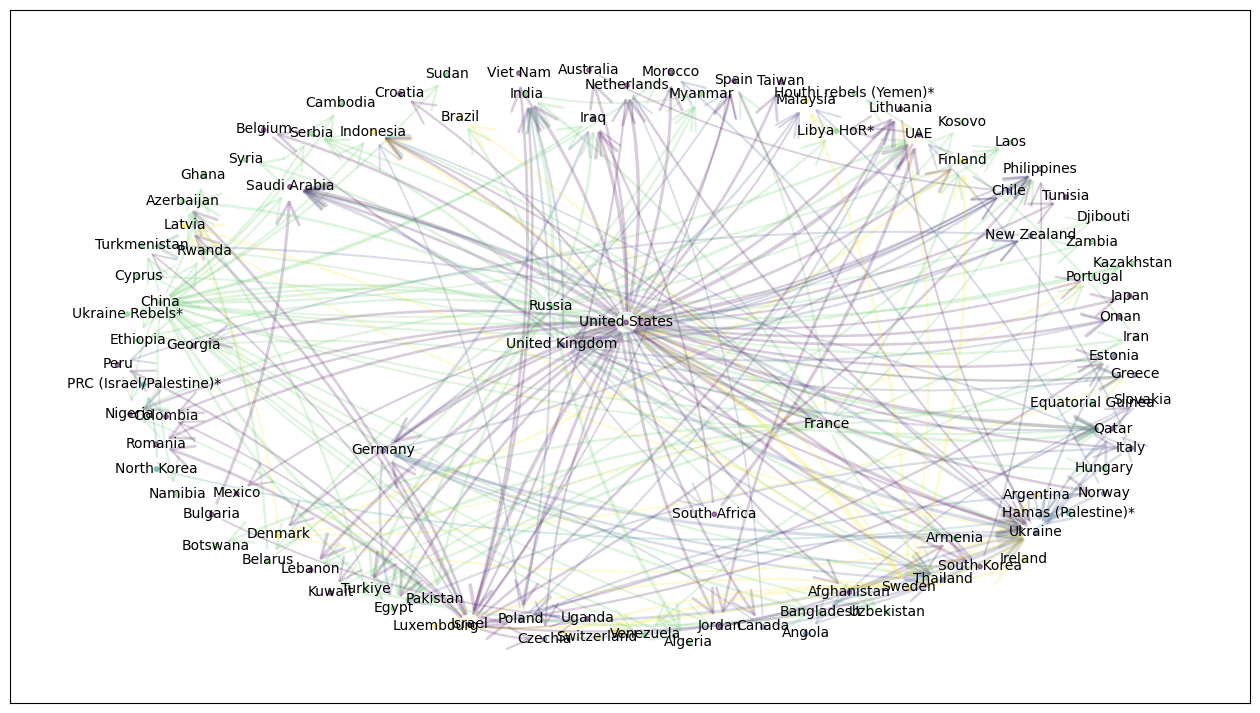

In [82]:
def plot_network(network: nx.DiGraph) -> None:
    fig, ax = plt.subplots(figsize=(16, 9))
    pos = nx.spring_layout(network, k=20, seed=42)
    # Set the figure and axis background color to match the map's background color
    fig.patch.set_facecolor('#ffffff')
    ax.set_facecolor('#ffffff')
    
    # set node size by attribute
    node_size = [max(data['betweenness_centrality'], 10) for node, data in network.nodes(data=True)]
    # node colour by attribute
    node_color = [data['louvain_community'] for node, data in network.nodes(data=True)]
    # Draw the graph with nodes at the projected positions
    nx.draw_networkx_nodes(network, pos, node_size=node_size, node_color=node_color, ax=ax, alpha=0.5)
    
    # add half of node size to y value of
    label_pos = {k: [v[0], v[1]+(s/5000)] for k, v, s in zip(pos.keys(), pos.values(), node_size)}
    nx.draw_networkx_labels(network, label_pos, font_size=10, font_family='sans-serif', ax=ax, font_color="black")
    
    edge_widths = []
    for u, v, d in network.edges(data=True):
        edge_widths.append(d['weight'] ** 0.10)

    edge_color = [network.nodes[u]['louvain_community'] for u, v in network.edges()]
    nx.draw_networkx_edges(network, pos, arrowstyle='->', arrowsize=40, edge_color=edge_color, ax=ax, alpha=0.2, width=edge_widths, connectionstyle='arc3,rad=0.1')
    plt.text(0.99, 0.01, f'© github/geometrein', verticalalignment='bottom', horizontalalignment='right', 
             transform=ax.transAxes, color='white', fontsize=20)
    plt.show()

plot_network(network)